In [85]:
#all imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
plt.rc("font", size=6)

import warnings
warnings.simplefilter(action='ignore')

In [86]:
# Read CSV
file_name1 = 'stroke.csv'
stroke_df = pd.read_csv(file_name1)

# preview data
print(stroke_df.describe())

# dataset
# https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0

In [87]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


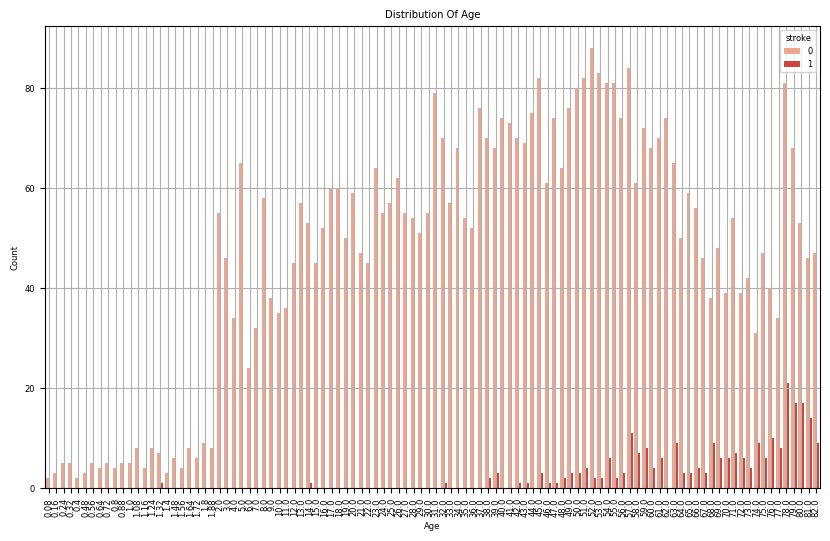

In [88]:
plt.figure(figsize=(10, 6))
sns.countplot(x='age', hue='stroke', data=stroke_df, palette='Reds')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.title("Distribution Of Age")
plt.grid(True)
plt.show()


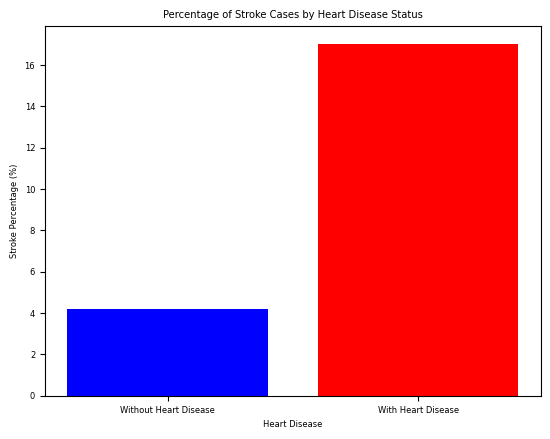

In [89]:
newyesHD = (stroke_df['heart_disease'] == 1).sum()
newnoHD = (stroke_df['heart_disease'] == 0).sum()

v1 = stroke_df[(stroke_df['stroke'] == 1) & (stroke_df['heart_disease'] == 0)].shape[0]
v2 = stroke_df[(stroke_df['stroke'] == 1) & (stroke_df['heart_disease'] == 1)].shape[0]

finalFirstValue = (v2 / newyesHD) * 100
finalSecondValue = (v1 / newnoHD) * 100

labels = ['Without Heart Disease', 'With Heart Disease']
values = [finalSecondValue, finalFirstValue]

plt.bar(labels, values, color=['blue', 'red'])
plt.xlabel('Heart Disease')
plt.ylabel('Stroke Percentage (%)')
plt.title('Percentage of Stroke Cases by Heart Disease Status')
plt.show()

In [90]:
print(stroke_df.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [91]:
(stroke_df['bmi'].isnull().sum()/len(stroke_df))*100

3.9334637964774952

In [92]:
stroke_df['bmi'].mean()

28.893236911794666

In [93]:
stroke_df['bmi'].median()

28.1

In [94]:
(stroke_df['avg_glucose_level'].isnull().sum()/len(stroke_df))*100

0.0

In [95]:
stroke_df['avg_glucose_level'].value_counts().idxmax()

93.88

In [96]:
stroke_df2 = stroke_df.copy()

median2 = stroke_df['bmi'].median()
stroke_df2['bmi'].fillna(median2, inplace = True)

most = stroke_df['avg_glucose_level'].value_counts().idxmax()
stroke_df2['avg_glucose_level'].fillna(most, inplace = True)

In [97]:
stroke_df2.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [98]:
#copy the df
training_data = stroke_df2.copy()
training_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [99]:
#Dropping columns
training_data = stroke_df2.copy()
training_data.drop(columns = "id", axis = 1, inplace = True)
training_data.drop(columns = "stroke", axis = 1, inplace = True)
training_data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked
...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.1,never smoked
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked


In [100]:
training_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


In [101]:
num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [102]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

In [103]:
preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

In [104]:
stroke_prepared = preprocessing.fit_transform(training_data)
stroke_prepared

array([[ 1.05143428, -0.32860186,  4.18503199, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.78607007, -0.32860186, -0.2389468 , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.62639008, -0.32860186,  4.18503199, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.36384151, -0.32860186, -0.2389468 , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.34379639, -0.32860186, -0.2389468 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.03420481, -0.32860186, -0.2389468 , ...,  0.        ,
         0.        ,  0.        ]])

LOGISTIC REGRESSION MODEL ACCURACY

In [105]:
X = stroke_prepared
y = stroke_df2['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_preprocessed = cat_pipeline.fit_transform(X_train)
X_test_preprocessed = cat_pipeline.transform(X_test)

pipeline1 = Pipeline(steps=[
    ('preprocessor', cat_pipeline),
    ('classifier', LogisticRegression(random_state=42))
])

pipeline1.fit(X_train, y_train)

y_pred = pipeline1.predict(X_test)

pipeline1

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore'))])),
                ('classifier', LogisticRegression(random_state=42))])

In [106]:
accuracy = pipeline1.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9373776908023483


In [107]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.3333333333333333
Recall: 0.03225806451612903
F1 Score: 0.058823529411764705


DNN

Epoch 1/100
128/128 - 2s - 14ms/step - accuracy: 0.9234 - loss: 0.2688 - val_accuracy: 0.9393 - val_loss: 0.1961
Epoch 2/100
128/128 - 0s - 2ms/step - accuracy: 0.9543 - loss: 0.1635 - val_accuracy: 0.9393 - val_loss: 0.1845
Epoch 3/100
128/128 - 0s - 3ms/step - accuracy: 0.9543 - loss: 0.1583 - val_accuracy: 0.9393 - val_loss: 0.1829
Epoch 4/100
128/128 - 0s - 2ms/step - accuracy: 0.9543 - loss: 0.1550 - val_accuracy: 0.9393 - val_loss: 0.1863
Epoch 5/100
128/128 - 0s - 3ms/step - accuracy: 0.9543 - loss: 0.1535 - val_accuracy: 0.9393 - val_loss: 0.1879
Epoch 6/100
128/128 - 0s - 2ms/step - accuracy: 0.9543 - loss: 0.1496 - val_accuracy: 0.9393 - val_loss: 0.1869
Epoch 7/100
128/128 - 0s - 3ms/step - accuracy: 0.9543 - loss: 0.1522 - val_accuracy: 0.9393 - val_loss: 0.1923
Epoch 8/100
128/128 - 0s - 2ms/step - accuracy: 0.9543 - loss: 0.1517 - val_accuracy: 0.9393 - val_loss: 0.1873
Epoch 9/100
128/128 - 0s - 2ms/step - accuracy: 0.9540 - loss: 0.1480 - val_accuracy: 0.9393 - val_loss

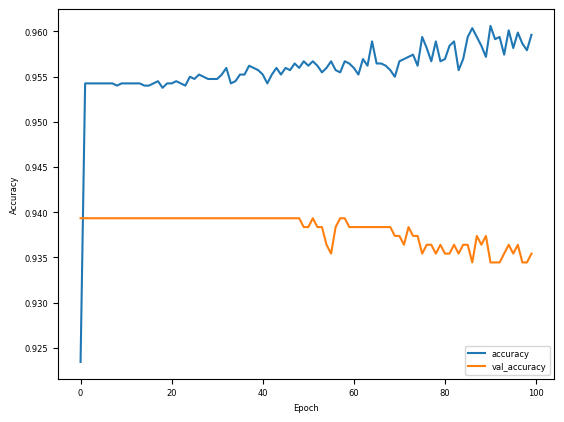

In [108]:
X = stroke_prepared
y = stroke_df['stroke']

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=2)

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Epoch 1/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9242 - loss: 0.2369 - val_accuracy: 0.9393 - val_loss: 0.1852
Epoch 2/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9485 - loss: 0.1615 - val_accuracy: 0.9393 - val_loss: 0.2042
Epoch 3/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9504 - loss: 0.1576 - val_accuracy: 0.9393 - val_loss: 0.1891
Epoch 4/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9539 - loss: 0.1474 - val_accuracy: 0.9393 - val_loss: 0.1823
Epoch 5/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9517 - loss: 0.1489 - val_accuracy: 0.9393 - val_loss: 0.1895
Epoch 6/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9543 - loss: 0.1517 - val_accuracy: 0.9393 - val_loss: 0.1853
Epoch 7/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9568 - loss: 0.1328 - val_accuracy: 0.9403 - val_loss: 0.1866
Epoch 8/100
511/511 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9554 - loss: 0.1397 - val_accu

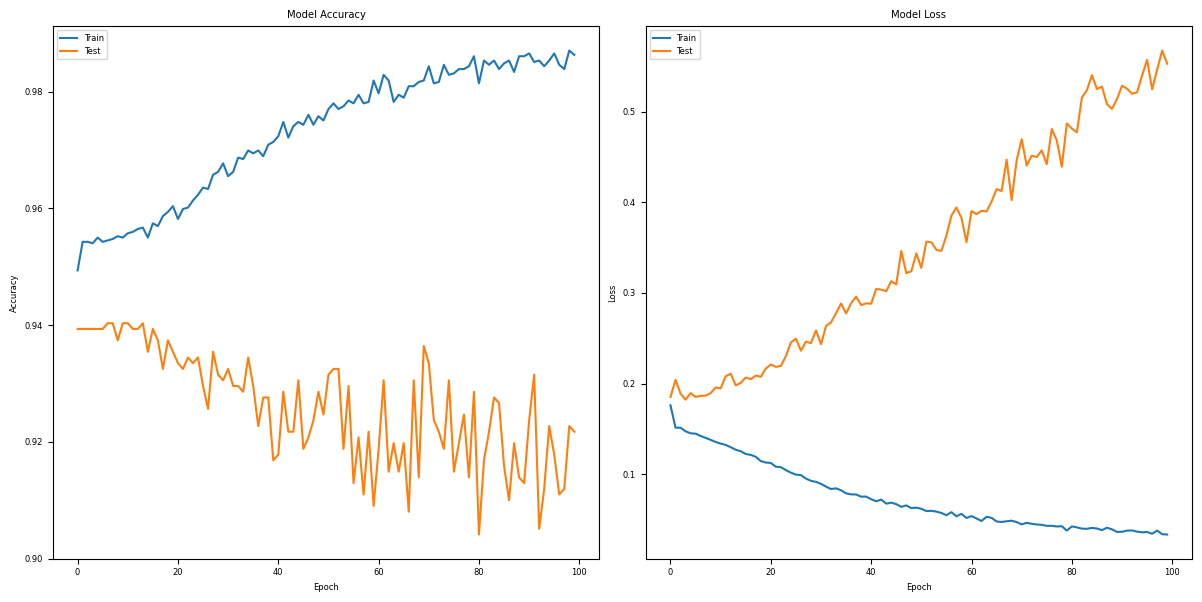

In [109]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

DNN CLASSIFICATION REPORT

In [110]:
from sklearn.metrics import classification_report

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

print(classification_report(y_test, y_pred))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       960
           1       0.18      0.08      0.11        62

    accuracy                           0.92      1022
   macro avg       0.56      0.53      0.54      1022
weighted avg       0.90      0.92      0.91      1022



In [111]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.17857142857142858
Recall: 0.08064516129032258
F1 Score: 0.1111111111111111


RANDOM FOREST ACCURACY

In [112]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = (rf_model.predict_proba(X_test)[:, 1] > 0.3)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

feature_importances = rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

Accuracy: 0.9275929549902152


In [113]:
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.2
Recall: 0.06451612903225806
F1 Score: 0.0975609756097561


SUPPORT VECTOR MACHINE

In [114]:
svm_model = SVC(kernel='linear', random_state=42)  
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9393346379647749


In [115]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm', SVC(kernel='rbf'))     
])

param_grid = {
    'svm__C': [0.1, 1, 10, 100],     
    'svm__gamma': [0.001, 0.01, 0.1] 
}

grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_svm_model = grid_search.best_estimator_

y_pred = best_svm_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       960
           1       0.33      0.06      0.11        62

    accuracy                           0.94      1022
   macro avg       0.64      0.53      0.54      1022
weighted avg       0.91      0.94      0.91      1022



In [116]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.3333333333333333
Recall: 0.06451612903225806
F1 Score: 0.10810810810810811
